In [34]:
# DELIVERABLE FOR THE PROJECT:
# "KINEMATICS OF MOBILITY"
# David Pastor-Escuredo (Life D Lab)
# Licencia MIT

In [35]:
#Copyright <2019> <David Pastor Escuredo>

#Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

#The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

#THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

In [36]:
import pandas as pd
import numpy as np
import json
from nltk.tokenize import word_tokenize
import re
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import collections
from sklearn.cluster import KMeans
from PIL import Image
import time
from datetime import datetime, timedelta, date
from os import listdir
from os.path import isfile, join
from geopandas import GeoDataFrame
from shapely.geometry import Point
import pickle
import math

%matplotlib inline

def getday(d):
    if d<10:
        ds='0'+str(d)
    else:
        ds=str(d)
    return ds

In [10]:
#Create a descriptor vector from the net values of the trajectories
netpath='./nets/'
trajpath='./trajs/'
UD={}
for yDay in range(1,2):
    with open(trajpath+'usersTracking'+'_'+str(yDay)+'.tff', 'rb') as fpp:
        usersTracking=pickle.load(fpp)
    with open(netpath+'ND'+'_'+str(yDay)+'.cnf', 'rb') as fpp:
        GD=pickle.load(fpp)
    with open(netpath+'Net'+'_'+str(yDay)+'.cnf', 'rb') as fpp:
        G=pickle.load(fpp)
        
    for u in usersTracking:
        avisited=usersTracking[u]['ss']
        tvisited=usersTracking[u]['ts']
        if u not in UD:
            UD[u]={}
            UD[u]['ind']=[]
            UD[u]['outd']=[]
            UD[u]['balance']=[]
            UD[u]['ind_dif']=[]
            UD[u]['outd_dif']=[]
            UD[u]['distance']=[]
            UD[u]['flow']=[]
            UD[u]['delta']=[]
            UD[u]['speed']=[]
        for i in range(1, len(avisited)+1):
            aid=avisited[i]    
            if aid in GD:
                ind=GD[aid]['ind']
                outd=GD[aid]['outd']
                
                UD[u]['ind'].append(ind)
                UD[u]['outd'].append(outd)
                bal=ind-outd
                UD[u]['balance'].append(bal)
                
                if i<len(avisited):
                    aid_next=avisited[i+1]
                    if aid_next in GD:
                        ind_n=GD[aid_next]['ind']
                        outd_n=GD[aid_next]['outd']
                        bal_n=ind_n-outd_n
                        w=G[aid][aid_next]['weight']
                        d=G[aid][aid_next]['distance']
                        delta=G[aid][aid_next]['time']
                        delta=delta/w#average time
                        speed=d/delta#average speed
                        UD[u]['ind_dif'].append(ind_n-ind)
                        UD[u]['outd_dif'].append(outd_n-outd)
                        UD[u]['balance_dif'].append(bal_n-bal)
                        UD[u]['flow'].append(w)
                        UD[u]['distance'].append(d)
                        UD[u]['delta'].append(delta)
                        UD[u]['speed'].append(speed)
            else:
                print(aid)
                print(u)
                
with open('traj-net/UD'+'.cnf', 'wb') as handle:
    pickle.dump(UD, handle, protocol=pickle.HIGHEST_PROTOCOL)         

KeyError: 0

   Unnamed: 0  LATITUD  LONGITUD Celda_HEX LAC_HEX antenna_id    municipio
0           0   4.6092  -74.0718      2711    083F   083F2711  BOGOTÁ D.C.
1           1   4.6092  -74.0718      2712    083F   083F2712  BOGOTÁ D.C.
2           2   4.6092  -74.0718      2713    083F   083F2713  BOGOTÁ D.C.
3           3   4.6092  -74.0718      2714    083F   083F2714  BOGOTÁ D.C.
4           4   4.6092  -74.0718      2715    083F   083F2715  BOGOTÁ D.C.
['083F2711' '083F2712' '083F2713' ..., '0596D58D' '0565D5C7' '0565D5C8']


In [42]:
#Create a descriptor vector from the net values of the trajectories just for Bogota
netpath='./nets/'
trajpath='./trajs/'

ant_file='antennas/antennas_bogota.csv'
sheet=pd.read_csv(ant_file,delimiter=',')
print(sheet.head())
target_aids=sheet['antenna_id'].values
print(len(target_aids)) 

UD={}
for yDay in range(1,2):
    with open(trajpath+'usersTracking'+'_'+str(yDay)+'.tff', 'rb') as fpp:
        usersTracking=pickle.load(fpp)
    with open(netpath+'ND'+'_'+str(yDay)+'.cnf', 'rb') as fpp:
        GD=pickle.load(fpp)
    
    for u in usersTracking:
        avisited=usersTracking[u]['ss']
        tvisited=usersTracking[u]['ts']
        for i in range(1, len(avisited)+1):
            aid=avisited[i]
            if aid in target_aids:
                if aid in GD:
                    ind=GD[aid]['ind']
                    outd=GD[aid]['outd']
                    if u not in UD:
                        UD[u]={}
                        UD[u]['ind']=[]
                        UD[u]['outd']=[]
                        UD[u]['balance']=[]
                    UD[u]['ind'].append(ind)
                    UD[u]['outd'].append(outd)
                    bal=ind-outd
                    UD[u]['balance'].append(bal)
                else:
                    print(aid)
                    print(u)

with open('traj-net/UD_bogota+'.cnf', 'wb') as handle:
    pickle.dump(UD, handle, protocol=pickle.HIGHEST_PROTOCOL)

   Unnamed: 0  LATITUD  LONGITUD Celda_HEX LAC_HEX antenna_id    municipio
0           0   4.6092  -74.0718      2711    083F   083F2711  BOGOTÁ D.C.
1           1   4.6092  -74.0718      2712    083F   083F2712  BOGOTÁ D.C.
2           2   4.6092  -74.0718      2713    083F   083F2713  BOGOTÁ D.C.
3           3   4.6092  -74.0718      2714    083F   083F2714  BOGOTÁ D.C.
4           4   4.6092  -74.0718      2715    083F   083F2715  BOGOTÁ D.C.
6757


In [46]:
UDesc={}
tag='_bogota'
tag=''
for yDay in range(1,2):
    with open('traj-net/UD'+tag+'.cnf', 'rb') as fpp:
        UD=pickle.load(fpp)
        
    for u in UD:
        if u not in UDesc:
            UDesc[u]={}
            UDesc[u]['inave']=0
            UDesc[u]['outave']=0
            UDesc[u]['balave']=0
        traj_in=UD[u]['ind']
        traj_out=UD[u]['outd']
        traj_bal=UD[u]['balance']
        lenTraj=len(traj_in)
        inave=0
        outave=0
        balave=0
        for i in range(0,lenTraj):
            inave=inave+traj_in[i]
            outave=outave+traj_out[i]
            balave=balave+traj_bal[i]
        inave=inave/lenTraj    
        outave=outave/lenTraj
        balave=balave/lenTraj
        UDesc[u]['inave']=inave
        UDesc[u]['outave']=outave
        UDesc[u]['balave']=balave
    
with open('traj-net/UD_Desc'+tag+'.cnf', 'wb') as handle:
    pickle.dump(UDesc, handle, protocol=pickle.HIGHEST_PROTOCOL)  
        
        

198391
198391
198391
(array([13]),)


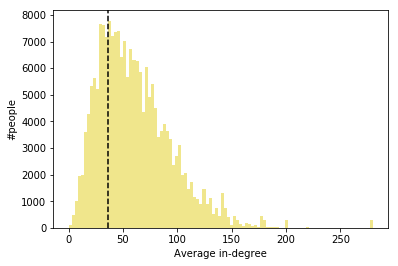

In [52]:
tag='_bogota'
#tag=''
with open('traj-net/UD_Desc'+tag+'.cnf', 'rb') as fpp:
    UDesc=pickle.load(fpp)

print(len(UDesc.keys()))
vector=[]
for u in UDesc:
    vector.append(UDesc[u]['inave'])
    
print(len(UDesc.keys()))
print(len(vector))
n, b, patches=plt.hist(vector,bins=100,color='khaki')
print(bin_max)
bin_max = np.where(n == n.max())
plt.axvline(x=b[bin_max][0], color='k', linestyle='--')
plt.xlabel("Average in-degree")
plt.ylabel("#people")

1822272
1822272
1822272
(array([12]),)


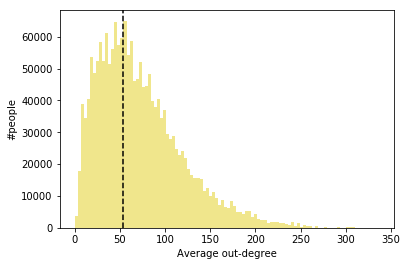

In [56]:
tag='_bogota'
tag=''
with open('traj-net/UD_Desc'+tag+'.cnf', 'rb') as fpp:
    UDesc=pickle.load(fpp)

print(len(UDesc.keys()))
vector=[]
for u in UDesc:
    vector.append(UDesc[u]['outave'])
    
print(len(UDesc.keys()))
print(len(vector))
n, b, patches=plt.hist(vector,bins=100,color='khaki')
print(bin_max)
bin_max = np.where(n == n.max())
plt.axvline(x=b[bin_max][0], color='k', linestyle='--')
plt.xlabel("Average out-degree")
plt.ylabel("#people")

1822272
1822272
1822272
(array([50]),)


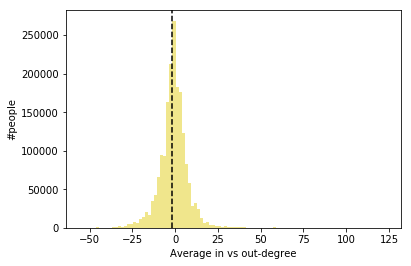

In [54]:
tag='_bogota'
tag=''
with open('traj-net/UD_Desc'+tag+'.cnf', 'rb') as fpp:
    UDesc=pickle.load(fpp)

print(len(UDesc.keys()))
vector=[]
for u in UDesc:
    vector.append(UDesc[u]['balave'])
    
print(len(UDesc.keys()))
print(len(vector))
n, b, patches=plt.hist(vector,bins=100,color='khaki')
print(bin_max)
bin_max = np.where(n == n.max())
plt.axvline(x=b[bin_max][0], color='k', linestyle='--')
plt.xlabel("Average in vs out-degree")
plt.ylabel("#people")